<a href="https://colab.research.google.com/github/anupamamnair/anupamamnair.github.io/blob/master/DSC624_LA3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Char-level Language Modelling

In [118]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns
import math

## Task 1: Load dataset

In [119]:
with open("names.txt", "r") as f:
    names = f.read().splitlines()

lengths = [len(name) for name in names]

print("Dataset size:", len(names))
print("First 10 names:", names[:10])
print("Min length:", min(lengths))
print("Max length:", max(lengths))
print("Average length:", sum(lengths) / len(lengths))

Dataset size: 32033
First 10 names: ['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia', 'harper', 'evelyn']
Min length: 2
Max length: 15
Average length: 6.122217712983486


The dataset name.txt is loaded and basic statistical analysis performed, comprising of dataset size, sample names, minimum, maximum and average word length.

## Task 2: Build character vocabulary

In [120]:
chars = sorted(list(set("".join(names))))
chars = ['.'] + chars

vocab_size = len(chars)

char_to_ix = {ch: i for i, ch in enumerate(chars)}
ix_to_char = {i: ch for ch, i in char_to_ix.items()}

print("Vocabulary size:", vocab_size)

print("\nCharacter to index mapping:")
mappings = [f"'{char}': {ix}" for char, ix in char_to_ix.items()]
print(', '.join(mappings))

print("\nIndex to character mapping:")
mappings_ix = [f"{ix}: '{char}'" for ix, char in ix_to_char.items()]
print(', '.join(mappings_ix))

Vocabulary size: 27

Character to index mapping:
'.': 0, 'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8, 'i': 9, 'j': 10, 'k': 11, 'l': 12, 'm': 13, 'n': 14, 'o': 15, 'p': 16, 'q': 17, 'r': 18, 's': 19, 't': 20, 'u': 21, 'v': 22, 'w': 23, 'x': 24, 'y': 25, 'z': 26

Index to character mapping:
0: '.', 1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z'


Character vocabulary created from given name + '.'

Then, char_to_ix and ix_to_char mappings crreated and displayed

## Task 3: Compute bigram counts and visualize

In [121]:
processed_names = []
for name in names:
    processed_names.append('.' + name + '.')

print("First 10 processed names:")
print(processed_names[:10])


First 10 processed names:
['.emma.', '.olivia.', '.ava.', '.isabella.', '.sophia.', '.charlotte.', '.mia.', '.amelia.', '.harper.', '.evelyn.']


In [122]:
counts = torch.zeros((vocab_size, vocab_size), dtype=torch.int32)

for name in processed_names:
    for ch1, ch2 in zip(name, name[1:]):
        i = char_to_ix[ch1]
        j = char_to_ix[ch2]
        counts[i, j] += 1


print("Shape of bigram frequency matrix COUNTS:", counts.shape)
print("First 5x5 slice of counts:\n", counts[:5, :5])

# Find the top 10 maximum entries in the counts matrix
flat_counts = counts.flatten()
top_10_values, top_10_indices = torch.topk(flat_counts, 10)

print("\nTop 10 most frequent bigrams:")
for k in range(10):
    value = top_10_values[k].item()
    flat_index = top_10_indices[k].item()
    row = flat_index // vocab_size
    col = flat_index % vocab_size
    char1 = ix_to_char[row]
    char2 = ix_to_char[col]
    print(f"'{char1}{char2}': {value}")

Shape of bigram frequency matrix COUNTS: torch.Size([27, 27])
First 5x5 slice of counts:
 tensor([[   0, 4410, 1306, 1542, 1690],
        [6640,  556,  541,  470, 1042],
        [ 114,  321,   38,    1,   65],
        [  97,  815,    0,   42,    1],
        [ 516, 1303,    1,    3,  149]], dtype=torch.int32)

Top 10 most frequent bigrams:
'n.': 6763
'a.': 6640
'an': 5438
'.a': 4410
'e.': 3983
'ar': 3264
'el': 3248
'ri': 3033
'na': 2977
'.k': 2963


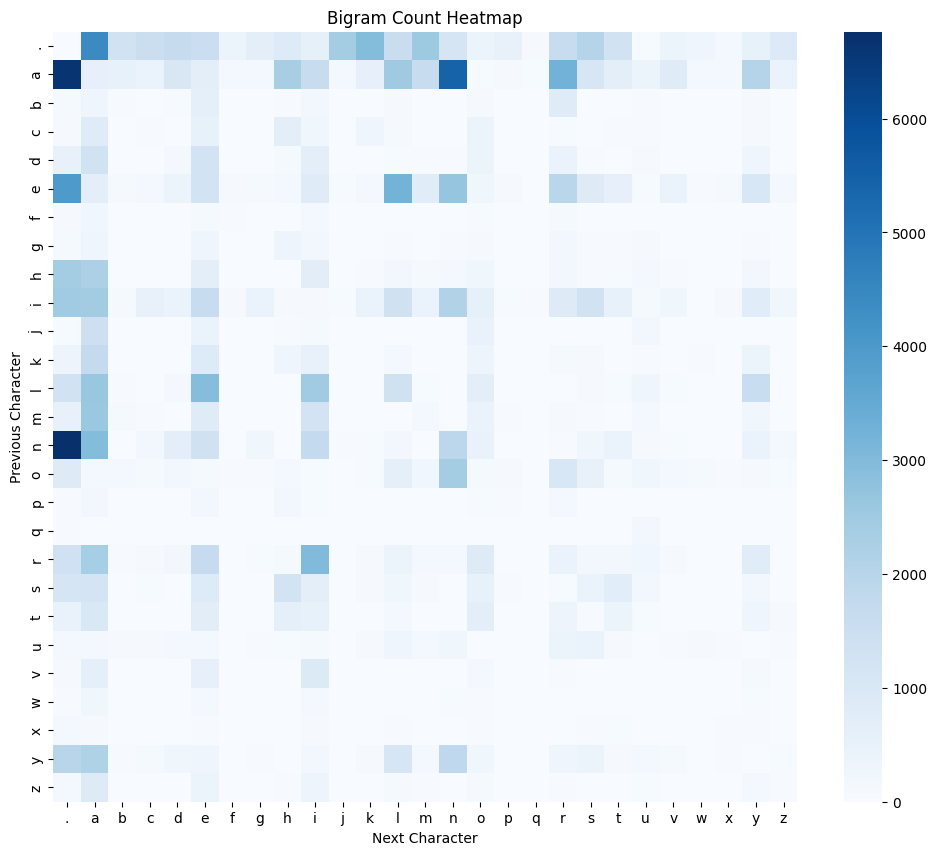

In [123]:
plt.figure(figsize=(12, 10))
sns.heatmap(counts.numpy(), xticklabels=chars, yticklabels=chars, cmap="Blues")
plt.title("Bigram Count Heatmap")
plt.xlabel("Next Character")
plt.ylabel("Previous Character")
plt.show()


Names are appended and prepended with '.'

Bigrams are created considering all pairs, resulting in 27 x 27 = 729 possibilities. It is depicted as a 27x27 order matrix.
Correesponding heatmap also created.
Top 10 most frequent bigrams:


* 'n.': 6763 => ending with n
* 'a.': 6640 => ending with a
* 'an': 5438
* '.a': 4410 => starting with a
* 'e.': 3983 => ending with e
* 'ar': 3264
* 'el': 3248
* 'ri': 3033
* 'na': 2977
* '.k': 2963 => starting with k

## Task 4: Convert counts to probabilities (MLE)

In [124]:
probs = counts.float()
probs /= probs.sum(dim=1, keepdim=True)

print("Shape of bigram probability matrix :", probs.shape)
print("First 5x5 slice of probs:")
print(probs[:5, :5])

row_sums = probs.sum(dim=1)
print("Row sum check:", probs.sum(dim=1)[:5])


Shape of bigram probability matrix : torch.Size([27, 27])
First 5x5 slice of probs:
tensor([[0.0000e+00, 1.3767e-01, 4.0770e-02, 4.8138e-02, 5.2758e-02],
        [1.9596e-01, 1.6408e-02, 1.5966e-02, 1.3870e-02, 3.0751e-02],
        [4.3100e-02, 1.2136e-01, 1.4367e-02, 3.7807e-04, 2.4575e-02],
        [2.7463e-02, 2.3075e-01, 0.0000e+00, 1.1891e-02, 2.8313e-04],
        [9.3886e-02, 2.3708e-01, 1.8195e-04, 5.4585e-04, 2.7111e-02]])
Row sum check: tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000])


#### Interpret probabilities as P(next | previous).

The Bigram Probability Matrix contains the conditional probabilities of observing a character j given that the previous character was i. Specifically, P[i, j] represents P(character j | character i). Each value P[i, j] indicates how likely it is for character j to follow character i in the names dataset. For example, if P[char_to_ix['a'], char_to_ix['n']] is high, it means the character 'n' frequently follows 'a' in the names.

From count matrix, the bigram probability matrix was obtained by normalizing each row of the count matrix, resulting in conditional probabilities
𝑃(𝑐𝑡+1∣𝑐𝑡), where each row represents a valid probability distribution over next characters given the current character.

We also verify each row sums up to 1.

## Task 5: Generate names from count-based model

In [125]:
uniform_probs = torch.ones((vocab_size, vocab_size)) / vocab_size


In [126]:
unigram_counts = torch.zeros(vocab_size)

for name in processed_names:
    for ch in name[1:]:
        unigram_counts[char_to_ix[ch]] += 1

unigram_probs = unigram_counts / unigram_counts.sum()


In [127]:
def sample_name(probs, max_len=20):
    ix = char_to_ix['.']
    name = []

    while True:
        ix = torch.multinomial(probs[ix], num_samples=1).item()
        ch = ix_to_char[ix]
        if ch == '.' or len(name) >= max_len:
            break
        name.append(ch)

    return "".join(name)


In [128]:
print("Uniform baseline samples:")
for _ in range(20):
    print(sample_name(uniform_probs))

print("\nCount-based bigram samples:")
for _ in range(20):
    print(sample_name(probs))

Uniform baseline samples:
jlh
ruwunv
eymgfdgetvdkqfdjtvqv
yzefbuusdxgpc
dxbymsxefmjcdlunxqdf
vhhbjcqcltfvuiimqpw
izycsfnmiknyvdxlqwar
opyu
nrxx
gmbkcelmlmz
hxibrexktjlyvruzgibs
zikksihkou
lklhqhipmajrvhucwjdy
lyfagwufnljlxulxotwm
gbxezc
iafjsfrqspjsxmuqcuh
ggvgvgdqacaismmvqybn
gjkiugjjbllyyeokncii
jpnklaspvyghkuqycjrs
amlazxldtsxlhnyuurok

Count-based bigram samples:
kloeifin
hewaden
fa
olyn
jolanon
saryi
cei
vizaili
abyat
kalayar
mor
grlyzaphi
e
kacone
f
a
e
abeliosryathendos
maradhnn
itt


In [129]:
# -------------------------------
# Sampling using backoff model
# -------------------------------

def sample_backoff(bigram_probs, unigram_probs, max_len=20):
    ix = char_to_ix['.']
    name = []

    while True:
        row = bigram_probs[ix]
        probs_next = row if row.sum() > 0 else unigram_probs

        ix = torch.multinomial(probs_next, 1).item()
        ch = ix_to_char[ix]

        if ch == '.' or len(name) >= max_len:
            break
        name.append(ch)

    return "".join(name)


In [130]:
print("Bigram + Backoff samples:")
for _ in range(20):
    print(sample_backoff(probs, unigram_probs))


Bigram + Backoff samples:
ja
dy
eenynnn
faysaracamirce
chelen
minanamira
helach
rueenn
gte
awirrlszy
l
zusa
zish
waryn
amin
cotenzirane
en
o
anzian
ha


Here uniform random baseline considered for further evaluation.
The uniform distribution was used as the baseline model, as it assigns equal probability to all characters and does not incorporate any information from the training data. This provides a meaningful lower bound for comparison with the count-based bigram language model.

Samples are generated for both bigram model and uniform baseline model.

Additionally bigram with backoff is also implemented to draw a comparison. For backoff, unigram is used.

## Task 6: Evaluate using NLL and Perplexity

In [131]:
def compute_nll(names, probs):
    total_log_likelihood = 0
    total_chars = 0

    for name in processed_names:
        for ch1, ch2 in zip(name, name[1:]):
            i = char_to_ix[ch1]
            j = char_to_ix[ch2]
            p = probs[i, j]
            total_log_likelihood += -torch.log(p)
            total_chars += 1

    return total_log_likelihood / total_chars


In [132]:
def compute_nll_backoff(names, bigram_probs, unigram_probs):
    total_nll = 0
    total_chars = 0

    for name in processed_names:
        for ch1, ch2 in zip(name, name[1:]):
            i = char_to_ix[ch1]
            j = char_to_ix[ch2]

            p = bigram_probs[i, j] if bigram_probs[i, j] > 0 else unigram_probs[j]
            total_nll += -torch.log(p)
            total_chars += 1

    return total_nll / total_chars


In [133]:
# -------------------------------
# Model comparison: NLL & Perplexity
# -------------------------------
nll_uniform = compute_nll(names, uniform_probs)
nll_bigram = compute_nll(names, probs)
nll_backoff = compute_nll_backoff(names, probs, unigram_probs)

print("NLL Comparison")
print("----------------")
print("Uniform  :", nll_uniform.item())
print("Bigram   :", nll_bigram.item())
print("Backoff  :", nll_backoff.item())

NLL Comparison
----------------
Uniform  : 3.2960469722747803
Bigram   : 2.454094171524048
Backoff  : 2.454094171524048


In [134]:
print("\nPerplexity Comparison")
print("---------------------")
print("Uniform  :", torch.exp(nll_uniform).item())
print("Bigram   :", torch.exp(nll_bigram).item())
print("Backoff  :", torch.exp(nll_backoff).item())



Perplexity Comparison
---------------------
Uniform  : 27.005674362182617
Bigram   : 11.635889053344727
Backoff  : 11.635889053344727


NLL and Perplexity are calculated for Bigram, Uniform, Backoff models. The uniform baseline exhibits the highest NLL and perplexity since it assigns equal probability to all characters regardless of context. The count-based bigram model significantly improves performance by conditioning on the previous character. The backoff model produces identical results to the bigram model because evaluation was performed on the same dataset used for training, resulting in no unseen bigrams and therefore no backoff activation. Backoff smoothing becomes beneficial when evaluating on unseen data or higher-order n-grams, where zero-probability events are common.

## Task 7: Bigram Neural Network

In [135]:
xs, ys = [], []

for name in processed_names:
    for ch1, ch2 in zip(name, name[1:]):
        xs.append(char_to_ix[ch1])
        ys.append(char_to_ix[ch2])

xs = torch.tensor(xs)
ys = torch.tensor(ys)


In [136]:
class BigramNN(nn.Module):
    def __init__(self, vocab_size):
        super().__init__()
        self.W = nn.Parameter(torch.randn(vocab_size, vocab_size))

    def forward(self, x):
        logits = self.W[x]
        return logits


In [137]:
model = BigramNN(vocab_size)
optimizer = torch.optim.Adam(model.parameters(), lr=0.05)

for epoch in range(501):
    logits = model(xs)
    loss = F.cross_entropy(logits, ys)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if epoch % 50 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.4f}")


Epoch 0, Loss: 3.8295
Epoch 50, Loss: 2.5361
Epoch 100, Loss: 2.4665
Epoch 150, Loss: 2.4592
Epoch 200, Loss: 2.4568
Epoch 250, Loss: 2.4558
Epoch 300, Loss: 2.4552
Epoch 350, Loss: 2.4549
Epoch 400, Loss: 2.4547
Epoch 450, Loss: 2.4545
Epoch 500, Loss: 2.4544


Dataset is prepared to suit Bigram usig Neual Network, and BigramNN created with Adam optimizer. Cross entropy as loss function. Network is trained for 500 epochs. Loss reduced from 3.6090 to 2.4565 approximately.

In [138]:
@torch.no_grad()
def sample_nn(model, max_len=20):
    ix = char_to_ix['.']
    name = []

    while True:
        logits = model(torch.tensor([ix]))
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs[0], 1).item()
        ch = ix_to_char[ix]
        if ch == '.' or len(name) >= max_len:
            break
        name.append(ch)

    return "".join(name)


In [139]:
print("Generated names (Neural Bigram):")
for _ in range(20):
    print(sample_nn(model))


Generated names (Neural Bigram):
jukielin
tiyonerian
rlaia
zar
lannn
jayn
r
belinaicakeret
tikyan
wyn
ssttakh
beisellelelviar
a
deylllennniarebriavi
abr
l
ckadana
ckona
miy
drerabelinara



Samples are generated for bigram neural network model.

In [140]:
@torch.no_grad()
def evaluate_nn(names, model):
    total_loss = 0
    total_chars = 0

    for name in processed_names:
        for ch1, ch2 in zip(name, name[1:]):
            i = char_to_ix[ch1]
            j = char_to_ix[ch2]
            logits = model(torch.tensor([i]))
            log_prob = F.log_softmax(logits, dim=1)[0, j]
            total_loss += -log_prob
            total_chars += 1

    nll = total_loss / total_chars
    return nll, torch.exp(nll)


In [141]:
nll_nn, ppl_nn = evaluate_nn(names, model)

print("Neural Bigram NLL:", nll_nn.item())
print("Neural Bigram Perplexity:", ppl_nn.item())


Neural Bigram NLL: 2.4544341564178467
Neural Bigram Perplexity: 11.639845848083496


NLL and Perplexity are calculated for Bigram NN models. The neural bigram model achieves NLL and perplexity comparable to the count-based bigram model.

In [142]:
print("\nFINAL MODEL COMPARISON")
print("----------------------")
print("Model     |  NLL   |  Perplexity ")
print("--------------------------------")

print(f"Uniform   | {nll_uniform.item():.4f} | {torch.exp(nll_uniform).item():.4f}")
print(f"Bigram    | {nll_bigram.item():.4f} | {torch.exp(nll_bigram).item():.4f}")
print(f"Backoff   | {nll_backoff.item():.4f} | {torch.exp(nll_backoff).item():.4f}")
print(f"Neural    | {nll_nn.item():.4f} | {ppl_nn.item():.4f}")


FINAL MODEL COMPARISON
----------------------
Model     |  NLL   |  Perplexity 
--------------------------------
Uniform   | 3.2960 | 27.0057
Bigram    | 2.4541 | 11.6359
Backoff   | 2.4541 | 11.6359
Neural    | 2.4544 | 11.6398


The uniform baseline model shows the highest negative log-likelihood (NLL = 3.2960) and perplexity (27.0057), as it assigns equal probability to all characters and ignores linguistic structure. The count-based bigram model significantly improves performance, achieving an NLL of 2.4541 and perplexity of 11.6359 by modeling conditional character probabilities. The backoff model produces identical results (NLL = 2.4541, perplexity = 11.6359) because training and evaluation were conducted on the same dataset, resulting in no unseen bigrams. The neural bigram model attains nearly identical performance with an NLL of 2.4544 and perplexity of 11.6398, with the slight difference attributable to approximate gradient-based optimization. While count-based models are optimal for small contexts with full data coverage, neural models offer better scalability and robustness for sparse or higher-order language modeling tasks.